In [3]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Create analysis sample

In [25]:
pathdir = "DataStore/2018-07-P2/Reg0726/"
dm = "docvecs"
rs = fastparquet.ParquetFile(pathdir+"reg_naics_name_sim_tr_0726.parq").to_pandas(['tp', 'op',
        'sim_{0}'.format(dm), 'tp_gyear', 'tp_naics_name',
       'tp_primclass', 'tp_inv_msa', 'op_naics_name', 'op_primclass',
       'op_inv_msa', 'inv_msa_match', 'primclass_match',
       'norm_sim_{0}'.format(dm), 'sim_mean_{0}_pc_msa'.format(dm), 
        'sim_mean_{0}_pc'.format(dm), 'year_group',
        'norm_sim_mean_{0}_pc'.format(dm), 'norm_sim_mean_{0}_pc_msa'.format(dm)])
rs2 = fastparquet.ParquetFile(pathdir+"naics_name_common_inv_0726.parq")\
.to_pandas(["tp", "op", "common_est_inv", "common_pat_inv", "lawyer_match", "num_common_cites", "common_cites_match"])
rs = rs.merge(rs2, how="left", on = ["tp", "op"])
del(rs2)

In [27]:
# Get tp-pc similarities
rs3 = pd.read_pickle(pathdir+"naics_name_tp_pc_msa_0824.pkl")[["tp", "sim_mean_{0}_tp_pc_msa".format(dm)]]
rs4 = pd.read_pickle(pathdir+"naics_name_tp_pc_0824.pkl")[["tp", "sim_mean_{0}_tp_pc".format(dm)]]
rs3 = rs3.merge(rs4, how="left", on = "tp").drop_duplicates()
del(rs4)

for c in ["sim_mean_{0}_tp_pc_msa".format(dm), "sim_mean_{0}_tp_pc".format(dm)]:
    # Get normed values for all similarities
    rs3["norm_{0}".format(c)] = np.nan
    rs3.loc[rs3[c].notnull(), "norm_{0}".format(c)] = \
    scaler.fit_transform(rs3.loc[rs3[c].notnull(), c].values.reshape(-1,1))
    
# Merge back with original
print(len(rs))
rs = rs.merge(rs3, how="left", on = "tp")
print(len(rs))
del(rs3)

1498184
1498184


In [29]:
fastparquet.write("DataStore/2018-08/Reg0820/naics_name_docvecs_0824.parq", rs, compression="GZIP")

### What's driving difference in *sim pc*, *sim pc msa* results?

In [4]:
ns = fastparquet.ParquetFile("DataStore/2018-08/Reg0820/naics_name_docvecs_0824.parq").to_pandas()

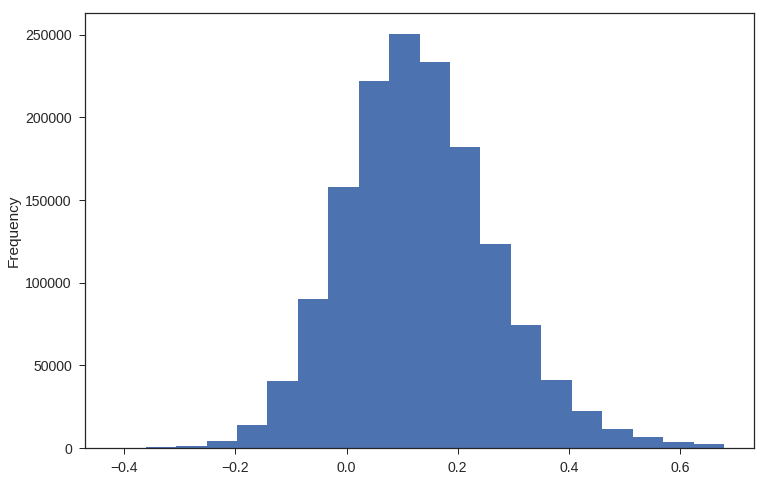

In [61]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,8))
ns["sim_docvecs"].plot.hist(bins=20,ax=ax)

In [63]:
np.round(ns["sim_docvecs"].describe(),2)

count    1481000.00
mean           0.13
std            0.14
min           -0.42
25%            0.04
50%            0.12
75%            0.21
max            0.68
Name: sim_docvecs, dtype: float64

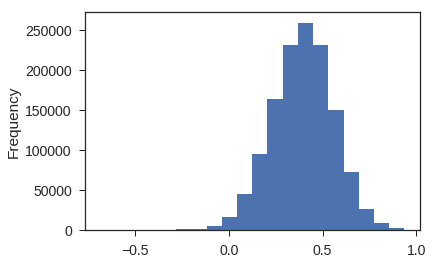

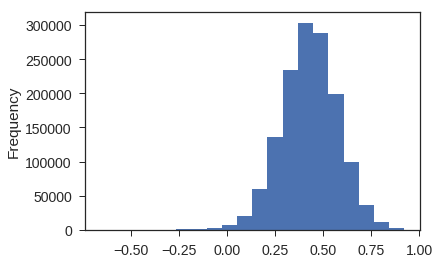

In [38]:
%matplotlib inline
ns["sim_mean_docvecs_tp_pc_msa"].plot.hist(bins=20)
plt.show()
ns["sim_mean_docvecs_tp_pc"].plot.hist(bins=20)
plt.show()
# Distributions

In [51]:
np.round(ns[["sim_mean_docvecs_tp_pc_msa","sim_mean_docvecs_tp_pc"]].describe(),3)

,sim_mean_docvecs_tp_pc_msa,sim_mean_docvecs_tp_pc
count,1306408.000,1401554.000
mean,0.394,0.428
std,0.162,0.145
min,-0.686,-0.662
25%,0.288,0.334
50%,0.398,0.430
75%,0.504,0.525
max,0.936,0.922


In [53]:
ns.loc[289212]

tp                                                                           7037953
op                                                                       7.28865e+06
sim_docvecs                                                                 0.524898
tp_gyear                                                                        2006
tp_naics_name                                                        Basic Chemicals
tp_primclass                                                                     522
tp_inv_msa                         New York-Northern New Jersey-Long Island, NY-N...
op_naics_name                                                        Basic Chemicals
op_primclass                                                                     540
op_inv_msa                         New York-Northern New Jersey-Long Island, NY-N...
inv_msa_match                                                                   True
primclass_match                                                  

In [60]:
ns.loc[1194309]

tp                                                                           7877619
op                                                                       7.96236e+06
sim_docvecs                                                                0.0901719
tp_gyear                                                                        2011
tp_naics_name                                      Computer and Peripheral Equipment
tp_primclass                                                                     713
tp_inv_msa                                          Austin-Round Rock-San Marcos, TX
op_naics_name                                      Computer and Peripheral Equipment
op_primclass                                                                     705
op_inv_msa                         New York-Northern New Jersey-Long Island, NY-N...
inv_msa_match                                                                  False
primclass_match                                                  

In [48]:
repl1 = pickle.load(open("DataStore/2018-07-P3/reg_names_dict.pkl", "rb"))

tp_pc = ns[["year_group", "sim_mean_docvecs_tp_pc_msa",\
    "sim_mean_docvecs_tp_pc"]].groupby("year_group").mean()
tp_pc_sd = ns[["year_group", "sim_mean_docvecs_tp_pc_msa",\
    "sim_mean_docvecs_tp_pc"]].groupby("year_group").std()
tp_pc_sd.columns = ["sd_"+c for c in tp_pc_sd.columns]

tp_pc = pd.concat([tp_pc, tp_pc_sd], axis=1).reset_index()
tp_pc = tp_pc[["year_group", "sim_mean_docvecs_tp_pc_msa", "sd_sim_mean_docvecs_tp_pc_msa", 
               "sim_mean_docvecs_tp_pc", "sd_sim_mean_docvecs_tp_pc"]]
tp_pc.columns = ["", repl1["sim_mean_docvecs_tp_pc_msa"], "SD", repl1["sim_mean_docvecs_tp_pc"], "SD"]

In [49]:
tp_pc

,,"$sim_DV(i,pc_{i,MSA_i})$",SD,"$sim_DV(i,pc_{i})$",SD
0,1975-85,0.376329,0.165483,0.428882,0.145707
1,1985-95,0.374007,0.166009,0.423738,0.145563
2,1995-05,0.392436,0.159858,0.424854,0.141971
3,2005-15,0.407718,0.158744,0.431224,0.146940


### Plotting conditional means on binned *sim pc*, *sim pc msa*

In [5]:
import math
def round_up(x, a):
    try:
        r = int(math.ceil(x / a)) * a
    except Exception:
        r = np.nan
    return r

ns["bin_norm_pc"] = ns["norm_sim_mean_docvecs_pc"].apply(lambda x: round_up(x,0.5))
ns["bin_norm_pc_msa"] = ns["norm_sim_mean_docvecs_pc_msa"].apply(lambda x: round_up(x,0.5))
ns["bin_pc"] = ns["norm_sim_mean_docvecs_pc"].apply(lambda x: round_up(x,0.1))
ns["bin_pc_msa"] = ns["norm_sim_mean_docvecs_pc_msa"].apply(lambda x: round_up(x,0.1))

In [6]:
# %matplotlib inline
sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 20})
savepath = "DataStore/2018-07-P3/ResultsGraphs/"
def p1(x, y, hue, data, bars, order, ax): 
    g = sns.pointplot(x = x, y = y, hue = hue, 
                data = data, ci = bars, markers = ".", 
                order = order, dodge = True, errwidth = 1,
                palette = sns.color_palette("Greys_r", 3),
                n_boot = 100,      
                  ax = ax)
    sns.despine()
    return g

    
def p2(x, y, data, order, ax, conf_int = None):
    g = sns.pointplot(x=x, y=y, data = data, ci = conf_int, join = True,
                 order = order, markers = ".", color="grey", ax = ax)
    sns.despine()
    return g
c_dict = pickle.load(open("DataStore/2018-06/col_names_dict.pkl", "rb"))

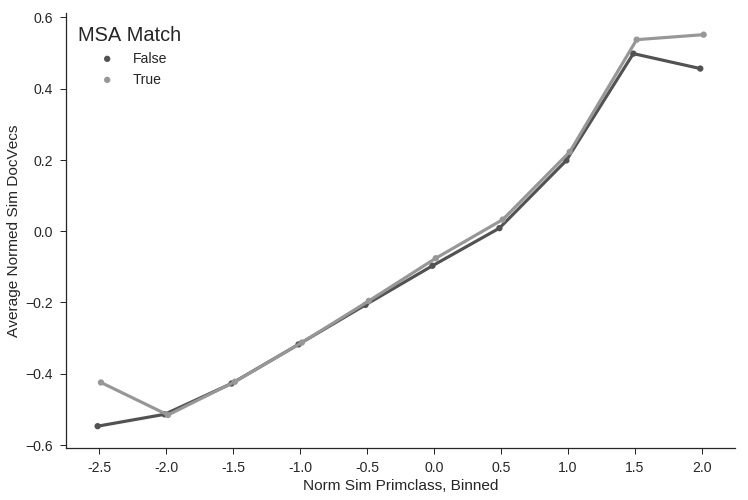

In [7]:
x1 = "bin_pc"
y1 = "norm_sim_docvecs"
hue1 = "inv_msa_match"
df = ns.loc[(ns["bin_pc"] >= -2.5)]
order1 = None
conf_int1 = None
fig, ax = plt.subplots(figsize=(12,8))
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = c_dict[hue1])

ax.set_xlabel(c_dict[x1])
ax.set_ylabel(c_dict[y1])
plt.savefig(savepath+"3b-MSASimPC-Mean.png")
plt.show()
del(fig, ax)

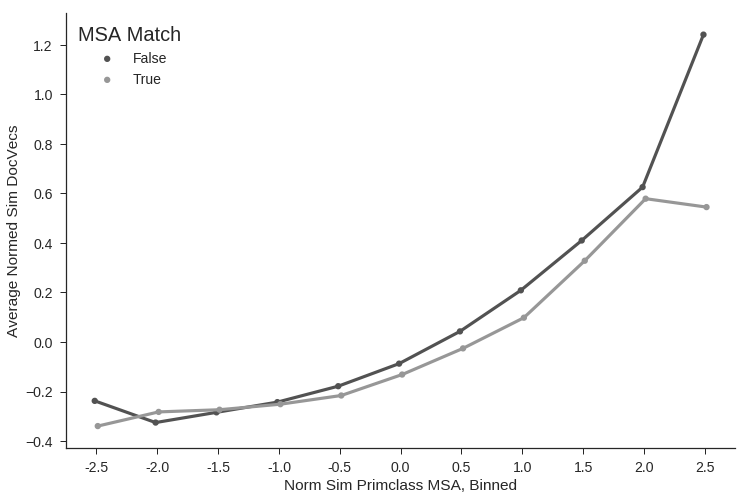

In [8]:
x1 = "bin_pc_msa"
y1 = "norm_sim_docvecs"
hue1 = "inv_msa_match"
df = ns.loc[(ns["bin_pc_msa"] >= -2.5)]
order1 = None
conf_int1 = None
fig, ax = plt.subplots(figsize=(12,8))
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = c_dict[hue1])

ax.set_xlabel(c_dict[x1])
ax.set_ylabel(c_dict[y1])
plt.savefig(savepath+"3b-MSASimPCMSA-Mean.png")
plt.show()
del(fig, ax)

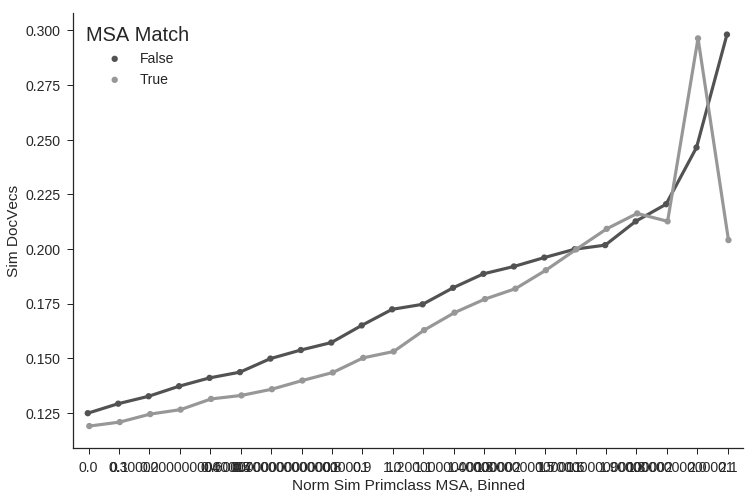

In [7]:
x1 = "bin_pc_msa"
y1 = "sim_docvecs"
hue1 = "inv_msa_match"
df = ns.loc[(ns["bin_pc_msa"] >= 0)]
order1 = None
conf_int1 = None
fig, ax = plt.subplots(figsize=(12,8))
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = c_dict[hue1])

ax.set_xlabel(c_dict[x1])
ax.set_ylabel(c_dict[y1])
# plt.savefig(savepath+"3b-MSASimPCMSA-Mean.png")
plt.show()
del(fig, ax)